## Time-dependent Heat or Diffusion Equation

#### Basic idea behind solving time-dependent (first order in time) problem in FEA

A simplest version of time-dependent heat equation for temperature $T$ (or diffusion with concentration $c$) the following form:

\begin{align}
{\partial T(x,y,t) \over \partial t} &= k \nabla^2 T(x,y,t) + s(x,y,t)\;\;\;\;\mbox{ over the domain}\\
T(x,y,t) &= T_D\;\;\;\;\mbox{ on the boundary}\\ 
T(x,y,0) &= T_0(x, y)\;\;\;\;\mbox{ initial condition}
\end{align}

Here, we note that $\nabla^2 = {\partial \over \partial x^2} + {\partial \over \partial y^2}$. The additional component that is present in the current problem is the initial condition, which defines what was the configuration of the system at $t = 0$, the initial time. Note that the boundary conditions could be of many variety as discussed in the earlier lectures. Here, however, we will only look at the simplest boundary condition. The question is how to solve the problem using FEA?

We utilize a very simple trick in which the derivative in time is approximately discretized. One of easiest way to express the first derivative is as follows.

$${\partial \over \partial t}T(x,y,t)  = k \nabla^2 T(x,y,t) + s(x,y,t),$$ 

is approximately written as:
$${T^{t + \Delta t} - T^{t} \over \Delta t} = \theta (k \nabla^2 T^{t+\Delta t} + s^{t+\Delta t}) + (1-\theta) (k \nabla^2 T^{t} + s^{t}),$$
where the super-script $t$ is the time and $\theta$ is a parameter that can vary between $0$ and $1$. This equation can be re-written to give an equation of the form:
$$T^{t + \Delta t} - T^t - \Delta t[\theta (k \nabla^2 T^{t+\Delta t} + s^{t+\Delta t}) - (1-\theta) (k \nabla^2 T^{t} + s^{t})] = 0.$$ 
What this means is that if we have somehow found $T^{t}$ then we get an $T^{t + \Delta t}$ solving the above boundary value problem, subject to the boundary conditions. It is obvious that  since the initial condition is known at $t = 0$, we can get started with the problem, and evaluate the value of $T$ at $\Delta t$, and that way can proceed further. 

#### Special cases for different values of $\theta$
When $\theta = 0$, this scheme is called as _explicit euler_ scheme. It means that by knowing the solution at $t = 0$ (initial condition), we can simply calculate what happens at $t + \Delta t$, and so on. The explicit schemes are generally known to be unstable for larger time-steps (we will see that in the code below.) The convergence rate for this scheme is $\Delta t^{1}$

When $\theta = 1$, the scheme is called as _implicit euler_. The scheme is known to be unconditionally stable, but the convergence rate is the same as that of explicit euler. 

When $\theta = 0.5$, this scheme is called as  [Crank-Nicholson](https://en.wikipedia.org/wiki/Crank–Nicolson_method) method. The convergence rate in many cases could now go as $\Delta t^2$. Check this [link](http://www.mathematik.uni-dortmund.de/~kuzmin/cfdintro/lecture8.pdf) for additional details. 

To summarize, we use a __finite difference__ scheme for time-derivative and solve the resulting problem as a BVP using FEA.

#### Method of manufactured solution for time-dependent problem

We solve this problem using FEniCS in the following manner. Consider a unit square domain. If we choose the conductivity $k = 1$, the BVP becomes


\begin{align}
{\partial T(x,y,t) \over \partial t} &=  \nabla^2 T(x,y,t) + s(x,y,t)\;\;\;\;\mbox{ over the domain}\\
T(x,y,t) &= T_D\;\;\;\;\mbox{ on the boundary}\\ 
T(x,y,0) &= T_0(x, y)\;\;\;\;\mbox{ initial condition}
\end{align}

and with a special case:

\begin{align}
T(x,y,t) &= 1 + x^2 + \alpha y^2 + \beta t\\
s(x,y,t) &= \beta - 2 - 2 \alpha
\end{align}

which clear satisfies the strong form of the differential equation, with the initial condition corresponding to $t = 0$ and the boundary conditions as per $t$ and $x,y$ on the boundaries. We now, solve this problem using FEniCS as follows:

#### FEniCS solution
The problem is taken from the FEniCS tutorial. The [program](https://github.com/hplgit/fenics-tutorial/blob/master/pub/python/vol1/ft03_heat.py) is kept on github. 

Below, we demonstrate the steps involved. First, we load all the libraries and define the relevant parameters required to solve. Please note that we use the variable $u$ for trial function and $v$ for test function. 

In [10]:
"""
FEniCS tutorial demo program: Heat equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.
  u'= Laplace(u) + f  in the unit square
  u = u_D             on the boundary
  u = u_0             at t = 0
  u = 1 + x^2 + alpha*y^2 + \beta*t
  f = beta - 2 - 2*alpha
"""

from __future__ import print_function
from dolfin import *
import numpy as np
%matplotlib inline

T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

Now, we define geometry and create the mesh. This is followed with creating a function space for the test (weight) and trial (temperature) functions. 

In [11]:
# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition. Note that the parameters can be passed as arguments to Expression
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

The weak form of the current problem will be:
$$T^{t + \Delta t} - T^t - \Delta t[\theta (k \nabla^2 T^{t+\Delta t} + s^{t+\Delta t}) - (1-\theta) (k \nabla^2 T^{t} + s^{t})] = 0.$$ 

Note that we define the initial value for temperature in variable `u_n`. This variable corresponds to $T^{t}$ in the theory above and the variable `u` corresponds to the solution at the current time $t + \Delta t$. Also, `f` corresponds to the source term $s$.

$$\int_\Omega T^{t+\Delta t} w d\Omega - \int_\Omega T^{t} w d\Omega + \theta \left(\int_\Omega k\nabla T^{t+\Delta t} \cdot \nabla w d\Omega - \int_{\Omega} s^{t + \Delta t}w d\Omega\right)\Delta t  + (1-\theta)  \left(\int_\Omega k\nabla T^{t} \cdot \nabla w d\Omega - \int_{\Omega} s^{t}w d\Omega\right)\Delta t = 0
$$

Now, define the weak form in FEniCS. 

In [ ]:
theta = 0.5
F = u*v*dx + theta*dt*inner(grad(u), grad(v))*dx + (1. - theta)*dt*inner(grad(u_n), grad(v))*dx - (u_n + dt*f)*v*dx
#F = u*v*dx + dt*inner(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
#F = u*v*dx + dt*inner(grad(u_n), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

Note that `F` corresponds to the expression for the weak form, for particular value of $\theta$, which equals $0.5$ correponding to Crank-Nicolson scheme. Note that in FEniCS `lhs(F)` correspond to all bi-linear term (both `u, v` or `grad(u), grad(v)`. In the current problem:

`lhs(F) = a = dt*inner(grad(u), grad(v))*dx + u*v*dx`

everything else will be stored in `rhs(F) = L`.

Now, we update the solution in time. The term `u_D.t = t` ensures that the boundary conditions are updated corresponding to time `t`. The command `solve(a == L, u, bc)` will save the solution in `u`. The solution that is obtained is now used to update the previous solution `u_n`. The solution then continues as we discussed above. 

In [ ]:
# Time-stepping
file = File("./Diffusion/output.pvd", "compressed")

u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, bc)
    

    # Plot solution
    plot(u)
    #plt.pause(0.5)

    # Compute error at vertices
    u_e = interpolate(u_D, V)
    error = np.abs(u_e.compute_vertex_values(mesh) - u.compute_vertex_values(mesh)).max()
    print('t = %.2f: error = %.3g' % (t, error))

    # Update previous solution
    u_n.assign(u)
    file << (u, t)

The output is saved in [Paraview](https://www.paraview.org). You can download it. The solution from each step is stored in `.vtu` file. The full code is given below. More details of the solution could be obtained from the [FEniCS tutorial](https://www.springer.com/gp/book/9783319524610) that is freely available. Look at Chapter 3 of that book.

The full code is given below. 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
t = 0.15: error = 3.55e-15
t = 0.30: error = 2.66e-15
t = 0.45: error = 4.44e-15
t = 0.60: error = 3.55e-15
t = 0.75: error = 4e-15
t = 0.90: error = 3.55e-15
t = 1.05: error = 4e-15
t = 1.20: error = 4.44e-15
t = 1.35: error = 4.44e-15
t = 1.50: error = 4.44e-15
t = 1.65: error = 6.22e-15
t = 1.80: error = 5.33e-15
t = 1.95: error = 4.44e-15
t = 2.10: error = 5.33e-15
t = 2.25: error = 6.22e-15
t = 2.40: error = 7.99e-15
t = 2.55: error = 7.11e-15
t = 2.70: error = 7.11e-15
t = 2.85: error = 7.11e-15
t = 3.00: error = 6.22e-15


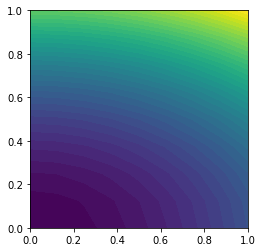

In [19]:
"""
FEniCS tutorial demo program: Heat equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.
  u'= Laplace(u) + f  in the unit square
  u = u_D             on the boundary
  u = u_0             at t = 0
  u = 1 + x^2 + alpha*y^2 + \beta*t
  f = beta - 2 - 2*alpha
"""

from __future__ import print_function
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

T = 3.0            # final time
num_steps = 20     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

theta = 0.5
F = u*v*dx + theta*dt*inner(grad(u), grad(v))*dx + (1. - theta)*dt*inner(grad(u_n), grad(v))*dx - (u_n + dt*f)*v*dx
#F = u*v*dx + dt*inner(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
#F = u*v*dx + dt*inner(grad(u_n), grad(v))*dx - (u_n + dt*f)*v*dx


a, L = lhs(F), rhs(F)
#a = dt*inner(grad(u), grad(v))*dx + u*v*dx
#L = (u_n + dt*f)*v*dx

#a = lhs(F)
#L = rhs(F)

# Time-stepping
file = File("./Diffusion/output.pvd", "compressed")

u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, bc)
    

    # Plot solution
    plot(u)
    #plt.pause(0.5)

    # Compute error at vertices
    u_e = interpolate(u_D, V)
    error = np.abs(u_e.compute_vertex_values(mesh) - u.compute_vertex_values(mesh)).max()
    print('t = %.2f: error = %.3g' % (t, error))

    # Update previous solution
    u_n.assign(u)
    file << (u, t)

# Hold plot
#interactive()